In [ ]:
import librosa
import os
import math
import json

import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np 

In [ ]:
#sample rate = default 22050 which is a good value.
#sample_duration = 1/sr 
#duration = sample_duration * len(signal) = 30 secs

## **VISUAL COMPARISON DIFERENT FEATURES**

In [ ]:
def plot_wave(sgn, name, i):

  plt.subplot(5,2,i+1)
  librosa.display.waveplot(sgn, alpha=0.5)
  plt.title(name.split('/')[0] +' waveform')
  plt.ylim((-1,1))

def plot_mel(sgn, src, name, i):

  plt.subplot(5,2,i+1)
  mel_spectrograms = librosa.feature.melspectrogram(sgn, sr=sr, n_fft=2048, hop_length =512, n_mels=10)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrograms)
  librosa.display.specshow(log_mel_spectrogram, x_axis='time', y_axis='mel', sr=sr)
  plt.colorbar()
  plt.title(name.split('/')[0] +' mel spectrogram')


def plot_mfcc(sgn, s, name, i):

  plt.subplot(5,2,i+1)
  mfccs = librosa.feature.mfcc(sgn, n_mfcc=13, sr=sr) #13 is traditional number
  librosa.display.specshow(mfccs, x_axis='time', sr=sr)
  plt.title(name.split('/')[0] +' MFCC')
  plt.colorbar()

def plot_chroma(sgn,sr,name,i):

  plt.subplot(5,2,i+1)
  chroma_feature = librosa.feature.chroma_stft(sgn, sr=sr, hop_length=512)
  librosa.display.specshow(chroma_feature, x_axis='time', y_axis='chroma', sr=sr)
  plt.title(name.split('/')[0] +' Chroma')
  plt.colorbar()

def plot_stft(sgn,sr,name,i):
#display Spectrogram
  sgn = librosa.stft(sgn)
  Xdb = librosa.amplitude_to_db(abs(sgn))
  plt.subplot(5,2,i+1)
  librosa.display.specshow(Xdb, x_axis='time', y_axis='stft', sr=sr)
  plt.title(name.split('/')[0] +' STFT')
  plt.colorbar()


In [ ]:
#take one sample of each genre 
genre_path = '/content/Data/genres_original/'

genres_path = ['blues/blues.00000.wav',
               'classical/classical.00000.wav',
               'country/country.00000.wav',
               'disco/disco.00000.wav',
               'hiphop/hiphop.00000.wav',
               'jazz/jazz.00000.wav',
               'metal/metal.00000.wav',
               'pop/pop.00000.wav',
               'reggae/reggae.00000.wav',
               'rock/rock.00000.wav'           
]

In [ ]:
!wget https://www.dropbox.com/s/ywf59s5uljcotwd/GTZAN.zip?dl=1

In [ ]:
!unzip /content/GTZAN.zip?dl=1

In [ ]:
#------------------- PLOT WAVE, CHROMA MEL SPECTROGRAM, MFCC FEATURES ----------------------- #
for k in range(5): 
  plt.figure(figsize=(40,20))
  for i, audio in enumerate(genres_path):

    #reconstruct the path to the audio
    audio_file = genre_path + audio

    #extract the signal and sample rate
    signal, sr = librosa.load(audio_file)

    #plot the waveform
    if k == 0: plot_wave(signal, audio, i)
    elif k ==1: plot_chroma(signal, sr, audio, i)
    elif k ==2: plot_mel(signal, sr, audio, i)
    elif k == 3: plot_mfcc(signal, sr, audio, i)

  plt.subplots_adjust(hspace=1)
  plt.show()

#----------------------- PLAY AUDIO -----------------------#
for audio in genres_path:
  #reconstruct the path to the audio
  audio_file = genre_path + audio
  
  ipd.Audio(audio_file)

Output hidden; open in https://colab.research.google.com to view.

## **CREATE DATA .JSON WITH MFCC FEATURES**

In [ ]:
#--------------------------- IMPORT AUDIOFILES FROM DROPBOX -------------------#

#the folder with the audio files is uploaded in dropbox and it is compresed 
!wget https://www.dropbox.com/s/ywf59s5uljcotwd/GTZAN.zip?dl=1
!unzip /content/GTZAN.zip?dl=1

In [ ]:
#GTZAN #30 SEC music 100 songs/genre, 10 genres #this is not to much
#num_segments, cut the 30 secs to have more training data

#ensure each segment has the same length to pass consistent input to machine learning 
import os
import librosa
import math
import json

dataset_path = '/content/Data/genres_original'
json_path = '/content/data.json'
SAMPLE_RATE = 22050
duration = 30 #seconds
samples_per_track = SAMPLE_RATE*duration


def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5): #json_path to save the output
  #dictionary to store the data 
    #mapping: #classical to 0 and blues to 1 etc 
    #mfcc: #mfcc vectors for each segment #they are training data/instances
    #labels: #they are the target for each vector of each segment in 'mfcc' 
  data = {
      'mapping': [],
      'mfcc':  [], 
      'labels': [] 
  }

  num_samples_per_segments = int(samples_per_track/num_segments)
  expect_mfcc = math.ceil(num_samples_per_segments / hop_length) #round to highest 1.2 -> 2 

  #loop through all genres 
  for i, (dirpath, dirnames, filesnames) in enumerate(os.walk(dataset_path)):
    #check that we're not in root label 
    if dirpath is not dataset_path: 

      #save the semantic label (mapping): classical, blues, etc.
      dirpath_components = dirpath.split('/') #genre/blues -> ['genre', 'blues']
      semantic_label = dirpath_components[-1]
      data['mapping'].append(semantic_label)
      print('\n Processing {}'.format(semantic_label))

      #process files for each genre
      for f in filesnames:

        #load audio file
        file_path = os.path.join(dirpath, f)
        try:
          signal, sr = librosa.load(file_path, sr = SAMPLE_RATE) #sr sample rate 
        except:
          print('cant load file:', f)
          
        #divide signal, process segments, extract mfcc and store data
        for s in range(num_segments):
          start_sample = num_samples_per_segments*s
          finish_sample = start_sample + num_samples_per_segments
          #mfcc for the current segment
          mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], 
                                        sr=sr, n_fft = n_fft, n_mfcc = n_mfcc, 
                                        hop_length= hop_length)
          mfcc = mfcc.T

          #check that the segment is the correct length 
          if len(mfcc) == expect_mfcc: 
            data['mfcc'].append(mfcc.tolist())
            data['labels'].append(i-1) #each iteration we are in a genre folder #the first iteration is for the datafolder of genrefolders
            print('{}, segment:{}'.format(file_path,s+1))

  #save the train data as json file 
  with open(json_path, 'a') as fp:
    json.dump(data, fp, indent=4)


if __name__ == '__main__':
  save_mfcc(dataset_path, json_path, num_segments=10)
       

## **CLASSICAL MODELS**

In [ ]:
import pickle
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt 

In [ ]:
#-------------- TRAIN MODELS AND SAVE ------------------ #
def train_svm(name, x_reshape, y_train):
  #define model
  clf = SVC(kernel = 'rbf', probability=True)
  #train model
  clf.fit(x_reshape, y_train)
  #save model
  filename = 'finalized_model_'+name+'.sav'
  pickle.dump(clf, open(filename, 'wb'))


def train_xgb(name, x_reshape, y_train):
  #define model
  clf = XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=3000,
                    n_jobs=-1, random_state=0, reg_alpha=0.2, 
                    colsample_bylevel=0.9, colsample_bytree=0.9)
  #train model
  clf.fit(x_reshape, y_train)
  #save model
  filename = 'finalized_model_'+name+'.sav'
  pickle.dump(clf, open(filename, 'wb'))

def train_lgmc(name, x_reshape, y_train):
  clf = LGBMClassifier(max_depth=5, learning_rate=0.05, n_estimators=1000,
                    n_jobs=-1, random_state=0, reg_alpha=0.2, 
                    colsample_bylevel=0.5, colsample_bytree=0.5)
  #train model
  clf.fit(x_reshape, y_train)
  #save model
  filename = 'finalized_model_'+name+'.sav'
  pickle.dump(clf, open(filename, 'wb'))

def train_random_forest(name, x_reshape, y_train):
  clf = RandomForestClassifier(max_depth=10, random_state=0)
  #train model
  clf.fit(x_reshape, y_train)
  #save model
  filename = 'finalized_model_'+name+'.sav'
  pickle.dump(clf, open(filename, 'wb'))


def train_logistic_regression():
  pass


In [ ]:
def load_data(dataset_path):
  with open(dataset_path, 'r') as f: 
    data = json.load(f)

  #convert list into np array
  inputs = np.array(data['mfcc'])
  targets = np.array(data['labels'])

  return inputs, targets


def plot_results(y_test, y_pred, name, target_names):
  #---------------------CONFUSSION MATRIX--------------------------------#
  cm=confusion_matrix(y_test,y_pred)
  df_cm = pd.DataFrame(cm, index =target_names, columns= target_names)
  plt.figure(figsize=(12,12))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size
  plt.title('Confussion matrix model: '+name)
  plt.show()

  #--------------------CLASSIFICATION REPORT MODEL----------------------#
  print('CLASSIFICATION REPORT MODEL: '+name)
  print(classification_report(y_test, y_pred, target_names=target_names))

  #----------------------ACCURACY------------------------------------#
  acc= accuracy_score(y_test, y_pred)*100
  print('Accuracy on test is: ',round(acc, 2),'%')


In [ ]:
#-------------------- IMPORT DATA FROM DROPBOX ---------------------- # (already converted to MFCCs)
!wget https://www.dropbox.com/s/dzefr0xqmoemc3t/data.json?dl=1
#-------------------- LOAD AND PREPARE DATA ----------------------------# 


--2021-03-29 05:44:57--  https://www.dropbox.com/s/dzefr0xqmoemc3t/data.json?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/dzefr0xqmoemc3t/data.json [following]
--2021-03-29 05:44:57--  https://www.dropbox.com/s/dl/dzefr0xqmoemc3t/data.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc38555f69124ff0ca4e5cfe5ada.dl.dropboxusercontent.com/cd/0/get/BLnPeGPkEPRf3MUzFCZR54I7-ksolgUXKbuTFEnJ1v75eo2F2guj2fYFueLgHkfpslSvykkqCf8Kvd_0imeUAYSBKJubnTjNpNBE_AhO4DfCoXwHV6vPo-v30V189IQyd3dEXIRNQN3s4rObmnkIY67V/file?dl=1# [following]
--2021-03-29 05:44:57--  https://uc38555f69124ff0ca4e5cfe5ada.dl.dropboxusercontent.com/cd/0/get/BLnPeGPkEPRf3MUzFCZR54I7-ksolgUXKbuTFEnJ1v75eo2F2guj2fYFueLgHkfpslSvykkqCf8Kvd_0imeUAYSBKJubnTjNp

In [ ]:
data_path = '/content/data.json?dl=1'
#load data
inputs, targets = load_data(data_path)

#split data into train and test
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.1)

#flatten the image
x_reshape = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test_reshape = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))


In [ ]:
#------------- TRAIN MODELS AND SAVE THEM ---------------------#
train = 'False'

if train == 'True':
  train_svm(name='svm', x_reshape=x_reshape, y_train=y_train)
  !mv '/content/finalized_model_svm.sav' '/content/drive/MyDrive/MACHINE LEARNING - MUSIC'
  train_random_forest(name='random_forest', x_reshape=x_reshape, y_train=y_train)
  !mv '/content/finalized_model_random_forest.sav' '/content/drive/MyDrive/MACHINE LEARNING - MUSIC'
  train_lgmc(name='lgmc', x_reshape=x_reshape, y_train=y_train)
  !mv '/content/finalized_model_lgmc.sav' '/content/drive/MyDrive/MACHINE LEARNING - MUSIC'
  train_xgb(name='xgb',x_reshape=x_reshape, y_train=y_train)
  !mv '/content/finalized_model_xgb.sav' '/content/drive/MyDrive/MACHINE LEARNING - MUSIC'
  #train_logistic_regression(name='logistic_regression', x_reshape=x_reshape, y_train=y_train)


wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


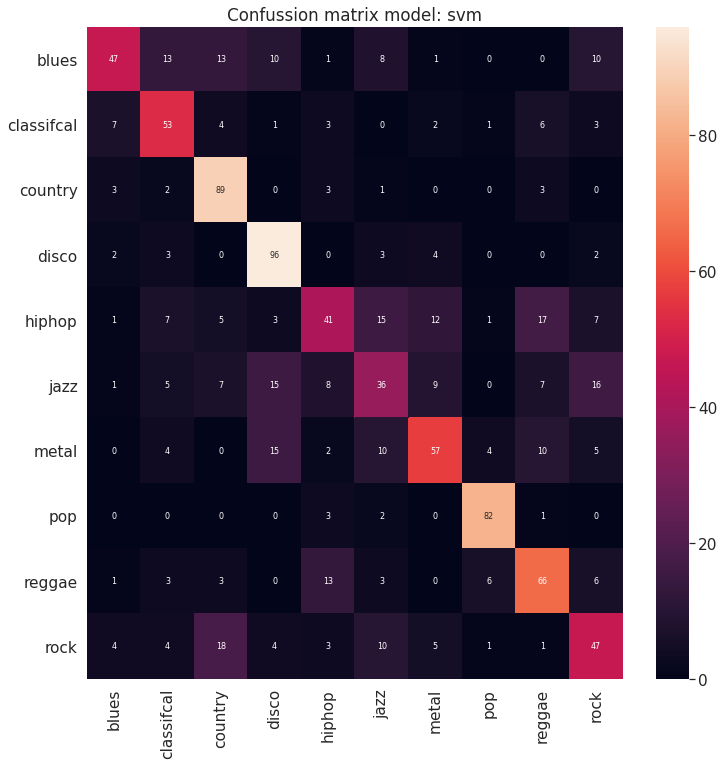

CLASSIFICATION REPORT MODEL: svm
              precision    recall  f1-score   support

       blues       0.71      0.46      0.56       103
  classifcal       0.56      0.66      0.61        80
     country       0.64      0.88      0.74       101
       disco       0.67      0.87      0.76       110
      hiphop       0.53      0.38      0.44       109
        jazz       0.41      0.35      0.38       104
       metal       0.63      0.53      0.58       107
         pop       0.86      0.93      0.90        88
      reggae       0.59      0.65      0.62       101
        rock       0.49      0.48      0.49        97

    accuracy                           0.61      1000
   macro avg       0.61      0.62      0.61      1000
weighted avg       0.61      0.61      0.60      1000

Accuracy on test is:  61.4 %
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


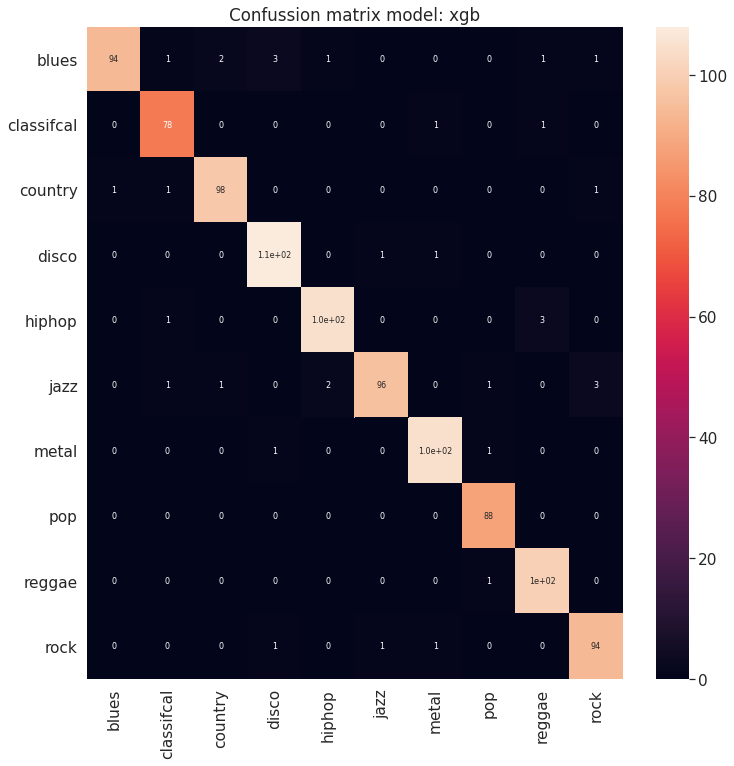

CLASSIFICATION REPORT MODEL: xgb
              precision    recall  f1-score   support

       blues       0.99      0.91      0.95       103
  classifcal       0.95      0.97      0.96        80
     country       0.97      0.97      0.97       101
       disco       0.96      0.98      0.97       110
      hiphop       0.97      0.96      0.97       109
        jazz       0.98      0.92      0.95       104
       metal       0.97      0.98      0.98       107
         pop       0.97      1.00      0.98        88
      reggae       0.95      0.99      0.97       101
        rock       0.95      0.97      0.96        97

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Accuracy on test is:  96.6 %
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


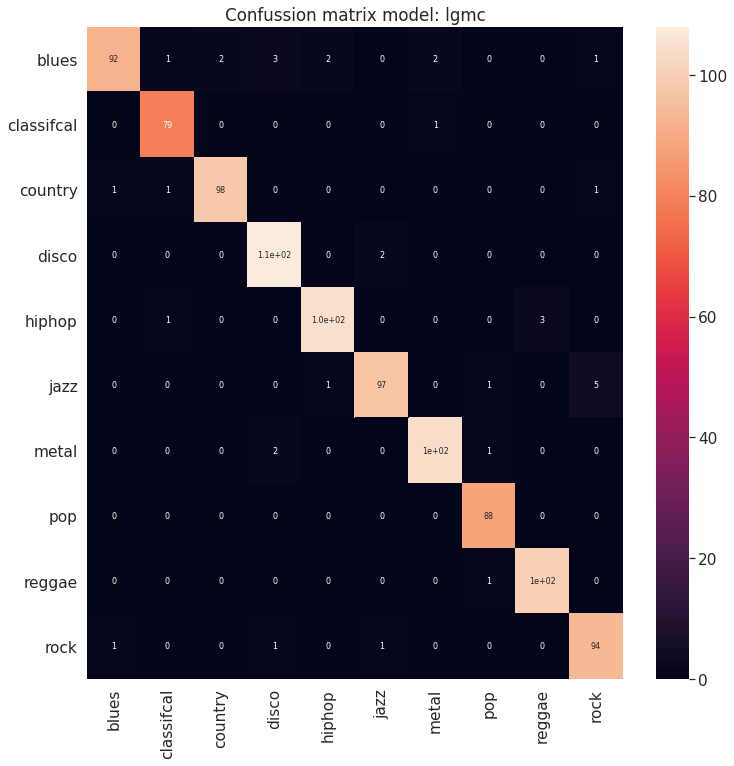

CLASSIFICATION REPORT MODEL: lgmc
              precision    recall  f1-score   support

       blues       0.98      0.89      0.93       103
  classifcal       0.96      0.99      0.98        80
     country       0.98      0.97      0.98       101
       disco       0.95      0.98      0.96       110
      hiphop       0.97      0.96      0.97       109
        jazz       0.97      0.93      0.95       104
       metal       0.97      0.97      0.97       107
         pop       0.97      1.00      0.98        88
      reggae       0.97      0.99      0.98       101
        rock       0.93      0.97      0.95        97

    accuracy                           0.96      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.96      0.96      1000

Accuracy on test is:  96.5 %
wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


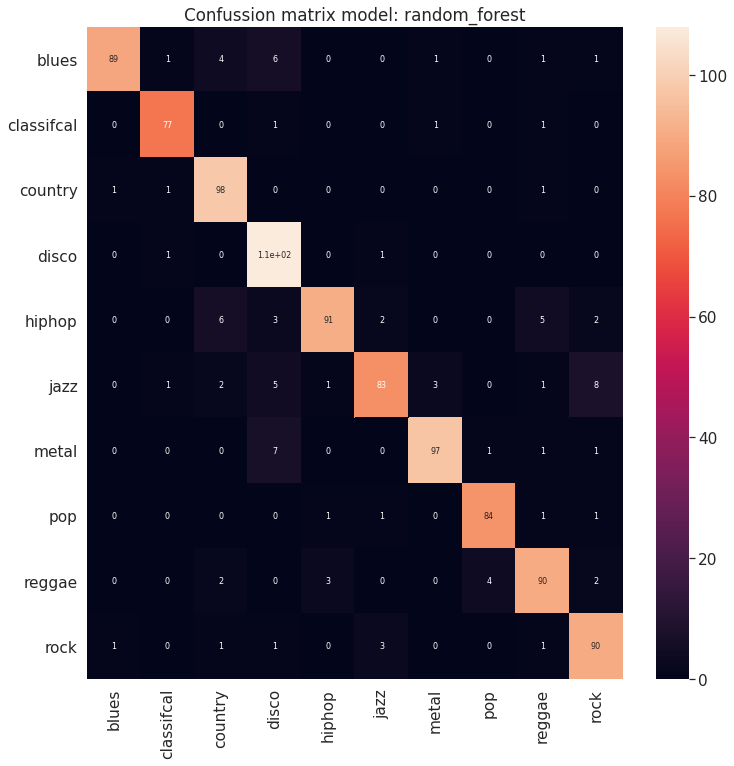

CLASSIFICATION REPORT MODEL: random_forest
              precision    recall  f1-score   support

       blues       0.98      0.86      0.92       103
  classifcal       0.95      0.96      0.96        80
     country       0.87      0.97      0.92       101
       disco       0.82      0.98      0.90       110
      hiphop       0.95      0.83      0.89       109
        jazz       0.92      0.80      0.86       104
       metal       0.95      0.91      0.93       107
         pop       0.94      0.95      0.95        88
      reggae       0.88      0.89      0.89       101
        rock       0.86      0.93      0.89        97

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

Accuracy on test is:  90.7 %


In [ ]:
#------------------SELECT MODEL AND PLOT RESULTS ---------------------#
target_names = ['blues','classifcal','country','disco','hiphop','jazz','metal','pop','reggae','rock']


model_name = ['svm', 'xgb', 'lgmc','random_forest']

for i in range(len(model_name)):
  #LOAD MODEL
  !wget #put link to model
  model_path = '/content/drive/MyDrive/MACHINE LEARNING - MUSIC/finalized_model_'+model_name[i]+'.sav'
  loaded_model = pickle.load(open(model_path, 'rb'))

  #PREDICT TEST DATASET
  y_pred2 = loaded_model.predict(x_test_reshape)

  #PRINT RESULTS
  plot_results(y_test=y_test, y_pred=y_pred2, name= model_name[i], target_names=target_names)
